In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

import gd_parameters as gd

from gd_cnn import CnnModel

/usr/local/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/usr/local/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/usr/local/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


In [2]:
plt.style.use("seaborn-white")

In [3]:
data_dir = gd.data_dir
subject_list = gd.subject_list
roi_list = gd.roi_list
feature_file = gd.feature_file
feature_type = gd.feature_type
result_dir = gd.result_dir
feature_file = gd.feature_file
feature_type = gd.feature_type
result_dir = gd.result_dir

In [4]:
# Feture selection settings
num_features = 1000

# CNN model settings
model_def = './data/cnn/alexnet_imagenet_full_conv/alexnet_imagenet_full_conv.prototxt'
model_param = './data/cnn/alexnet_imagenet_full_conv/alexnet_imagenet_full_conv.caffemodel'
cnn_layers = ('conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6-conv', 'fc7-conv', 'fc8-conv')

mean_image_file = './data/images/ilsvrc_2012_mean.npy'  # ImageNet Large Scale Visual Recognition Challenge 2012

# Misc settings
rand_seed = 2501

model = CnnModel(model_def, model_param, mean_image_file, batch_size=128, rand_seed=rand_seed)
net = model.net
feat_ind = model.feat_index

In [5]:
def get_channel(blob, n):
    """
    return index of channel wehere unit n in blob belongs to
    """
    ind = feat_ind[blob][n - 1]
    blob_shape = net.blobs[blob].data[0].shape
    resolution = blob_shape[1] * blob_shape[2]
    channel = ind // resolution
    
    return blob, channel

In [6]:
def top_decodable(sbj, roi, n=10):
    acc_unit_temp = acc_unit[acc_unit["subject"] == sbj][acc_unit["ROI"] == roi]
    acc_sorted = acc_unit_temp.sort_values("accuracy", ascending=False)
    top_decodable = []
    for i in range(n):
        top_decodable.append((acc_sorted.iloc[i]["feature"], acc_sorted.iloc[i]["unit"]))
    return top_decodable

In [7]:
def get_ordered_iou(blob,channel):
    """return ordered_iou averaged in a layer as pandas.Series
    use ration of channels exceeding threshold
    """
    path= os.path.join("/home/nakamura/network_dissection/NetDissect/dissection/alexnet_imagenet_full_conv_384",
                       blob + "-iou.csv")
    iou = pd.read_csv(path, index_col=0)
    channel_iou = iou.iloc[channel]
    sorted_iou = channel_iou.sort_values(ascending=False)

    return sorted_iou

In [8]:
with open("./results_alex/UnitAccuracy.pkl") as f:
    acc_unit = pickle.load(f)

In [9]:
# eliminate fc8-conv from analysis
acc_unit = acc_unit[acc_unit["feature"] != "fc8-conv"]

In [10]:
def top_decodable_channel(sbj, roi, n=10):
    top = top_decodable(sbj, roi, n)
    top_channel = []
    for i in range(len(top)):
        top_channel.append(get_channel(top[i][0], top[i][1]))
    return top_channel

In [11]:
%matplotlib inline
def plot_iou_top(ax, blob,channel, N):
    raw_iou = get_ordered_iou(blob, channel)
    iou = raw_iou.values
    label = raw_iou.index.tolist()
    
    bottom = range(N)
    iou_top = iou[:N][::-1]
    label_top = label[:N][::-1]
    
    # plot
    
    ax.barh(bottom, iou_top,height=0.5, align="center")
    ax.set_title("IoU of channel {}: layer:{}".format(channel, blob))
    ax.set_ylim(-1, N)
    #ax.set_yticks(np.arange(0,N + 1),label_top) 
    ax.set_yticks(np.arange(0, N+1))
    ax.set_yticklabels(label_top) 
    ax.set_xlabel("IoU")

    return ax

/home/python/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


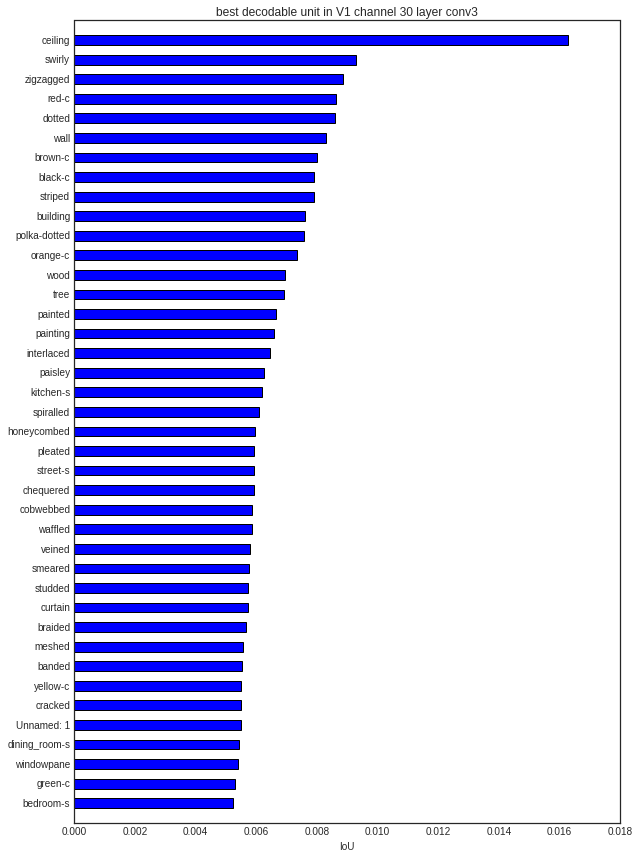

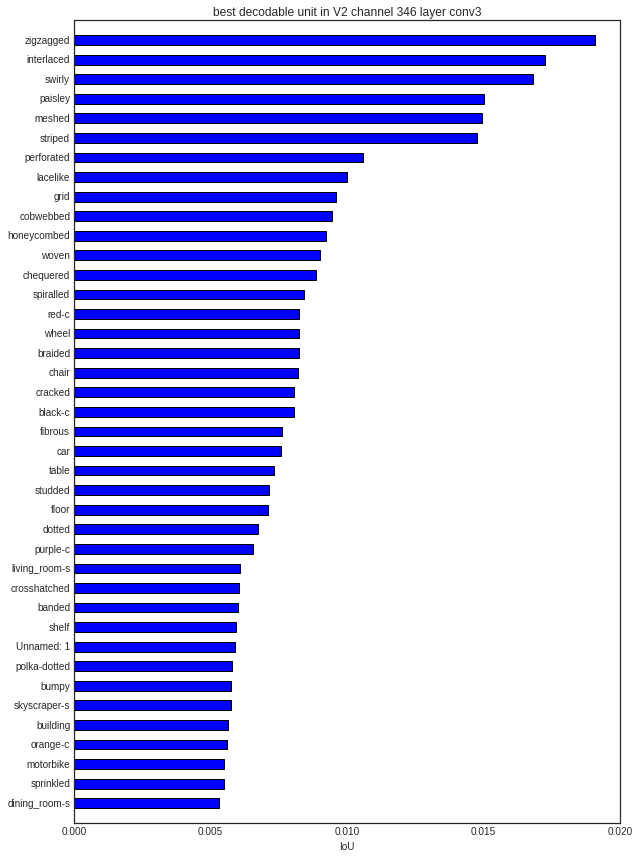

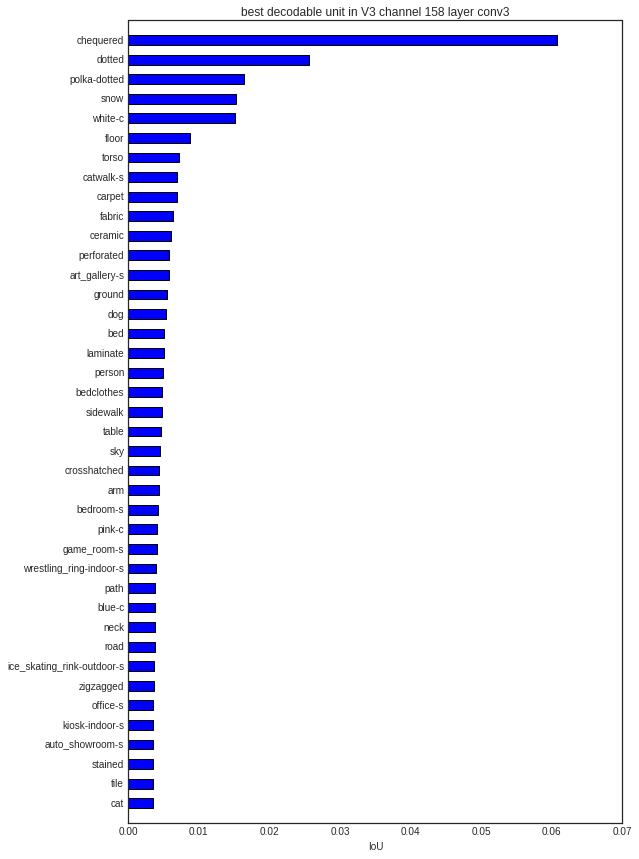

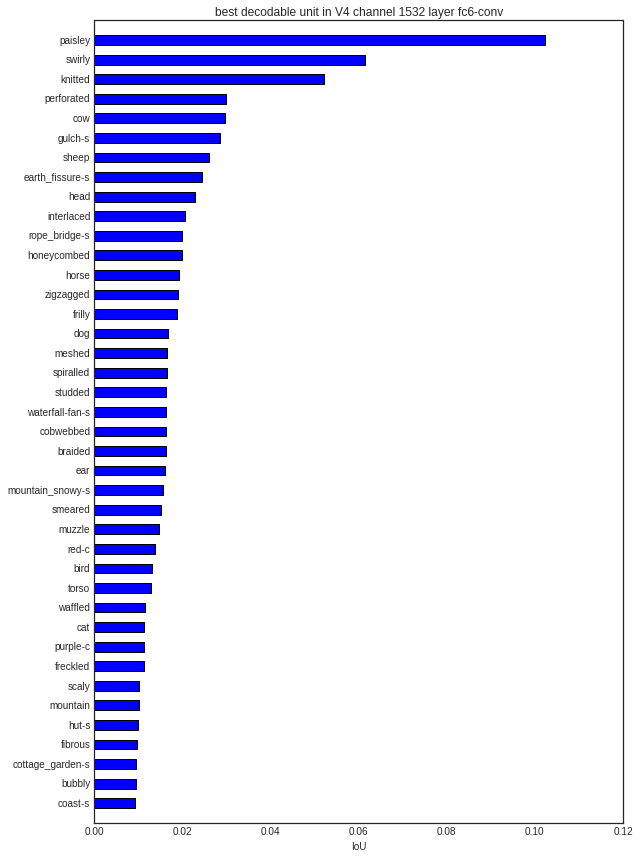

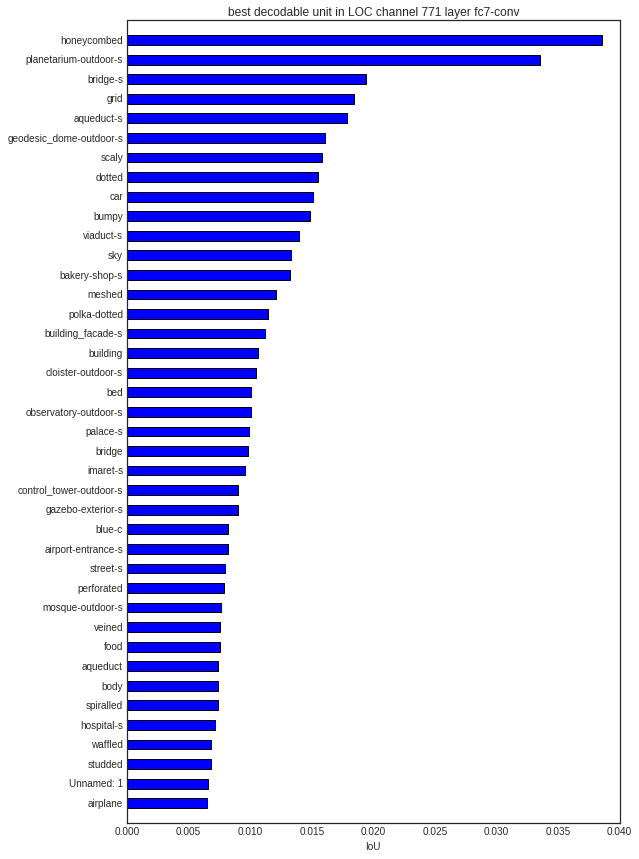

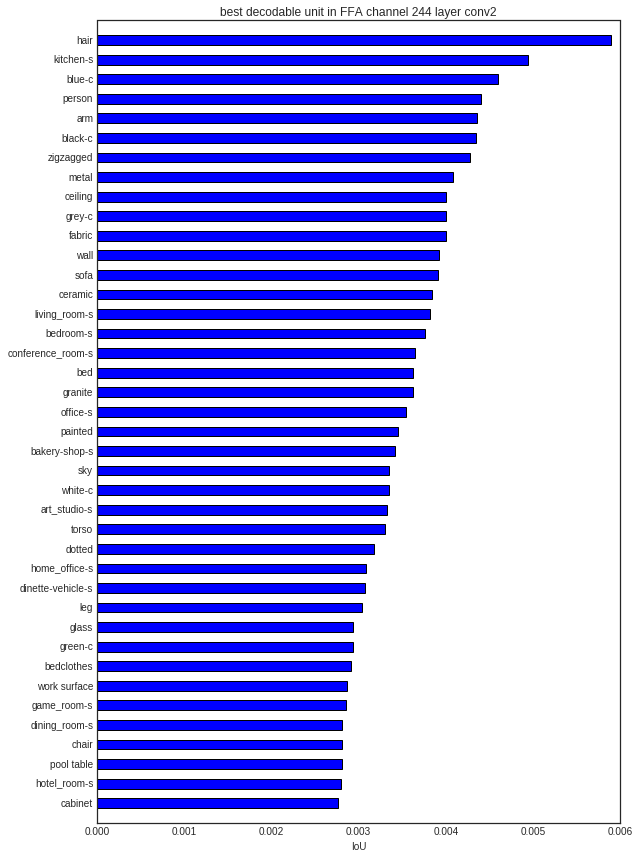

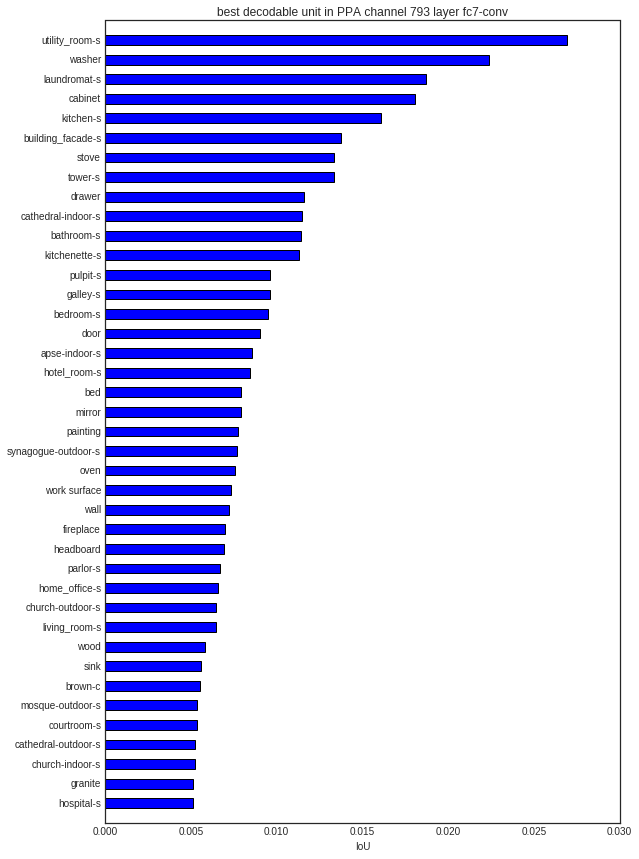

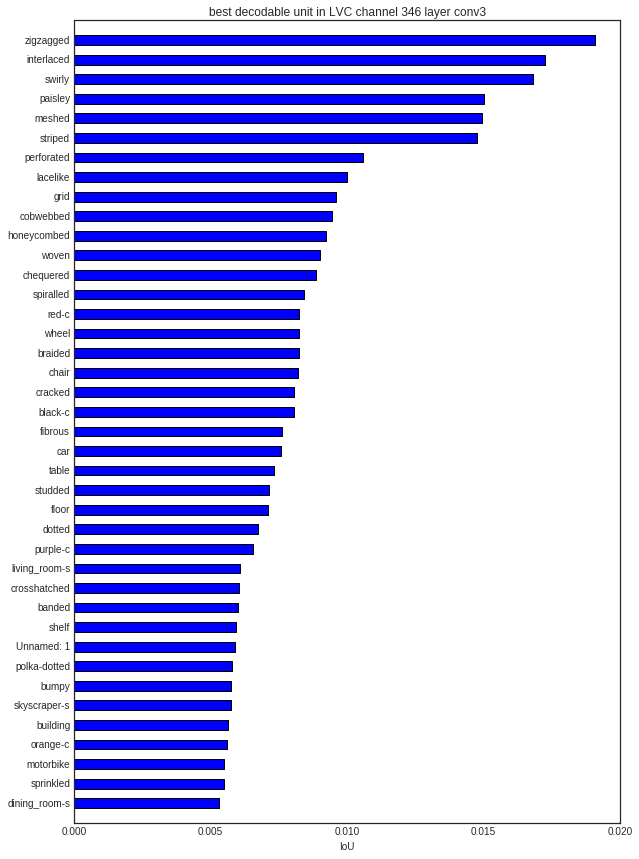

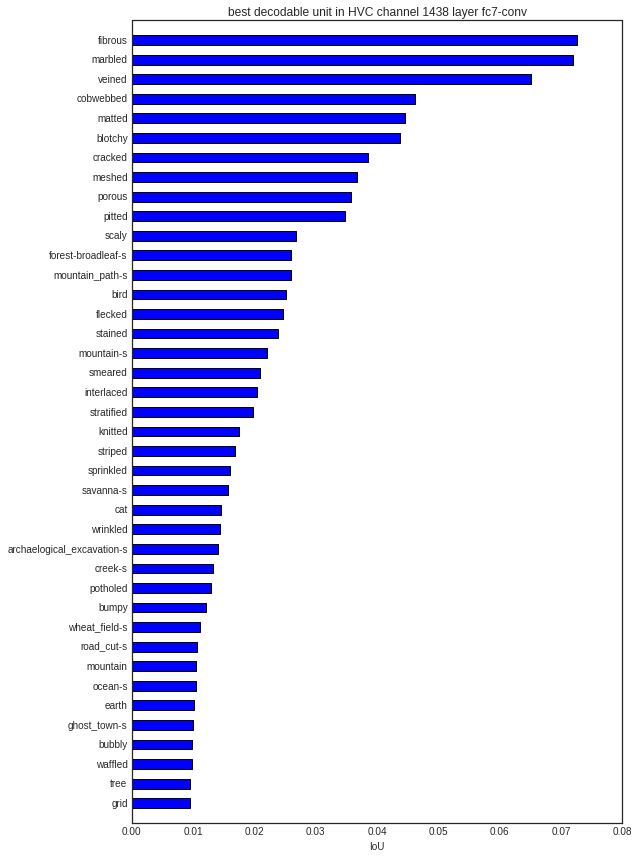

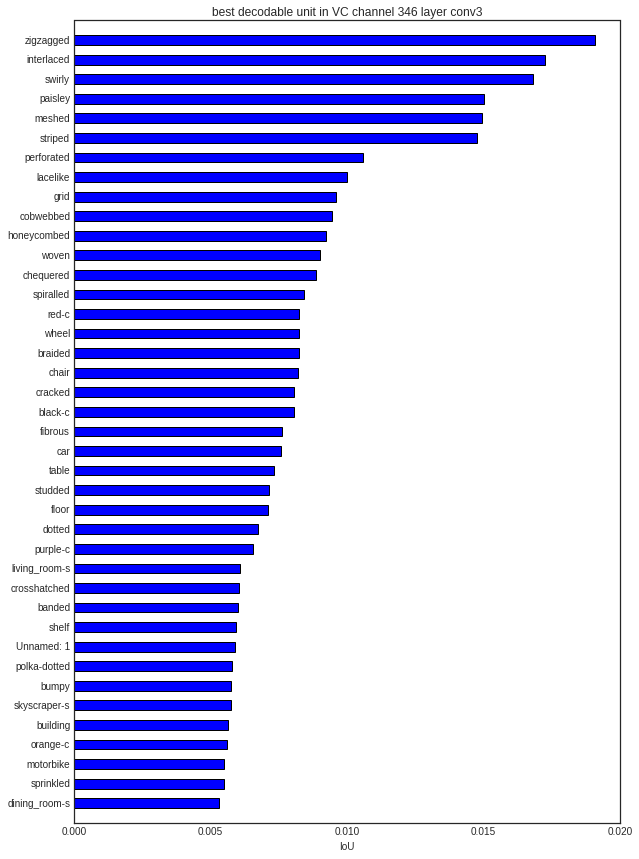

In [12]:
sbj = "Subject1"
for roi in roi_list:    
    top_channel = top_decodable_channel(sbj, roi)
    best_channel = top_channel[0]
    fig, ax = plt.subplots(figsize=(9, 12))
    ax = plot_iou_top(ax, *best_channel, N=40)
    ax.set_title("best decodable unit in {} channel {} layer {}".format(roi, best_channel[1], best_channel[0]))
    fig.tight_layout()
    fig.savefig(os.path.join("./figures/", "best_decodable_unit_{}_{}.pdf".format(roi, sbj)))

In [15]:
# make tab separated table
sbj = "Subject1"
n = 10
df = pd.DataFrame(index=np.arange(1,n + 1),columns=roi_list)

for roi in roi_list:

    top_channel = top_decodable_channel(sbj, roi)
    for i in range(n):
        # get ordered iou of top nth best decodable
        iou = get_ordered_iou(*top_channel[i])
        label = iou.index.tolist()
        concepts = ",".join(label[:10])
        df[roi].iloc[i]= concepts 

df.to_csv(os.path.join("./figures/" ,"decodable_concept_{}.csv").format(sbj), sep="\t")

/home/python/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
